In [3]:
import os
import sys
sys.path.append("..")
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
# from mrcnn.config import Config
# import mrcnn.utils
# import mrcnn.model as modellib
# import mrcnn.visualize
# from mrcnn.model import log
import json
import imageio
import warnings
import pickle as pkl
warnings.filterwarnings('ignore')
from pathlib import Path
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
pickle_path = './../intraoperativeperformance/FeatureEngineering_Analysis/all_results/1527/kp_X.pkl'

with open(pickle_path, 'rb') as p:
    try:
        values = pkl.load(p)
        print(values)
        p.close()
    except EOFError:
        print('EOF error :(')
        pass

[[{'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}]]


In [5]:
print(len(values))

1


In [6]:
print(values[0][0]['X'].shape)
mosaic = values[0][0]['X']

(45204, 160)


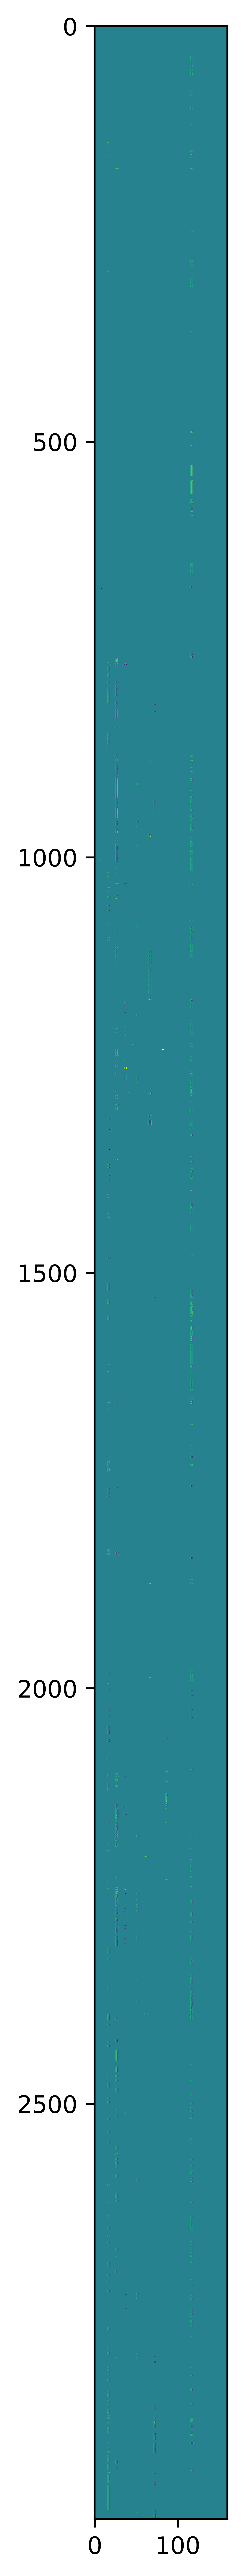

In [12]:
plt.figure(figsize=(1,50), dpi=1000)
plt.imshow(mosaic[:3000,:])

In [8]:
print(list(values[0][0].keys())[0:5])

['X']


In [9]:
kps = values[list(values.keys())[0]]

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
print('Key Points: '+str(kps))

In [ ]:
print(len(kps['kp']))

In [ ]:
# Extract the OSATS data from the labels.txt file
# folder , tool , ext , t0 , t1 , Respect for tissue , Time and Motion , Instrument handling , Knowledge of instruments , Use of assistance , Flow of operation and forward planning , Knowledge of specific procedure
df = pd.read_csv('./../csv-data/OSATS_per4/labels.txt', delimiter=' , ')
print(df.keys())

In [ ]:
# Get the OSATS score for the specific 20 minute segment
dataf = df[df['folder'].str.contains('658NX8JNU65X73R8_N7J6G3U76_3')]['folder']
print(dataf)

In [ ]:
print(dataf.values[0])

In [ ]:
# Initialize a feature vector
NO_OF_TOOLS = 23
LABELS_FOR_CLASSIFICATION = 1
FEATURE_LEN = len(kps['kp'])
VECTOR_LEN = NO_OF_TOOLS*FEATURE_LEN
DATA_LEN = len(list(values.keys()))
X = np.zeros((DATA_LEN,VECTOR_LEN))
y = np.zeros((DATA_LEN,LABELS_FOR_CLASSIFICATION))
ALL_DATA_X = []
ALL_DATA_y = []
# Order of tools 
# (Ideally, the order of the tools will alway be fed into the mode at the same time)
tools = ['grasper']

print('Length of list (before extraction): {}'.format(len(list(values.keys()))))

kp_list = list(values.keys())
kp_list.sort()

for i, item in enumerate(kp_list):
    kps = values[item]
    print(kps)
    # Go through each of the tools and capture the associated data
    for j, tool in enumerate(tools):
        if (len(kps['kp']) != 0):
            if (tool==kps['kp']['class']):
                # Add a flag for the presence of the class 
                X[i,j] = 1

                # Add a value for the cx
                X[i,j] = kps['kp']['cx']

                # Add a value for the cy
                X[i,j] = kps['kp']['cy']

                # Add a value for the alpha
                X[i,j] = kps['kp']['alpha']

                # Add a value for the length
                X[i,j] = kps['kp']['length']

                # Add the label here
                y[i] = df[df['folder'].str.contains(item.split('-')[0])]['Time and Motion'].values[0]
    
    ALL_DATA_X.append([{'X': X}])
    ALL_DATA_y.append([{'y': y}])
    
    # Clear the data
    X = np.zeros((DATA_LEN,VECTOR_LEN))
    y = np.zeros((DATA_LEN,LABELS_FOR_CLASSIFICATION))
    X_train = 0
    X_test = 0
    y_train = 0 
    y_test = 0
    
    # Calculate the z-score if needed


In [ ]:
print('Dims of VECTOR array (after extraction): {}'.format(X.shape))

In [ ]:
print(len(kps['kp']))

In [ ]:
# Split the data (into training/testing)
X_train, X_test, y_train, y_test = train_test_split(ALL_DATA_X, ALL_DATA_y, test_size=0.1)

# Split the data (into training/validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

ALL_DATA_TRAIN = {'X': X_train, 'y': y_train}
ALL_DATA_VALID = {'X': X_valid, 'y': y_valid}
ALL_DATA_TEST = {'X': X_test, 'y': y_test}

In [ ]:
print(('Shape of X_train is {}').format(len(X_train)))
print(('Shape of X_valid is {}').format(len(X_valid)))
print(('Shape of X_test is {}').format(len(X_test)))
print(('Shape of y_train is {}').format(len(y_train)))
print(('Shape of y_valid is {}').format(len(y_valid)))
print(('Shape of y_test is {}').format(len(y_test)))

In [ ]:
data = [ALL_DATA_TRAIN, ALL_DATA_VALID, ALL_DATA_TEST]
pickle_path_train = './output/data_train.pkl'
pickle_path_valid = './output/data_valid.pkl'
pickle_path_test = './output/data_test.pkl'
files = [pickle_path_train, pickle_path_valid, pickle_path_test]

In [ ]:
# Write to different files
for i, file in enumerate(files):
    # Create the file if it doesn't exist 
    if not os.path.exists(file):
        Path(file).touch()

    # Write to the file
    with open(file, 'wb') as f:
        pkl.dump(data[i], f)
    f.close()

In [ ]:
with open('./output/data_train.pkl', 'rb') as f:
    data = pkl.load(f)
    print(len(data))
    
with open('./output/data_valid.pkl', 'rb') as f:
    data = pkl.load(f)
    print(len(data))
    
with open('./output/data_test.pkl', 'rb') as f:
    data = pkl.load(f)
    print(len(data))

In [ ]:
print(len(data['y'][2][0]['y'][0]))